In [565]:
import os
import shutil
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Combining and Analyzing Two Stage Model Data : 
## Images -> Yolov5 & Tracker Results -> Regression/Binary Classification Outputs
This notebook is designed to feed a Stage 1 Model (Yolov5 + Object Tracker) for a set of images, get the corresponding output as a DataFrame, add in labeled image data (technically classified 0-9, then converted to a regression sequence 0-.9) from a directory, combine and run two models on it, one for regression 0 -> 1, and one as a binary classified sequence (0 or 1 : low traffic or congested roadway).

DATE : the date for the generated dataset, this decides what CSVs to reference automatically, but they can be manually chosen with individual filepaths or another unique identifier. <br>
classif_dir : Directory containing structures of classified images. Structure means a parent directory that should contain subdirectories for each class name, the contents of each subdirectory is therefore labeled according to the subdirectory name. <br>
- classif_label_dir : specific structure containing labeled directories full of images <br>
db_dir : Path to the directory storing raw image subdirectories, which were labeled according to collection date in this case. <br>
test_set_directory : directory in storage to be used as input to the Stage 1 after an associated CSV is generated <br>
main_dir : parent directory for the below directories containing only CSVs <br>
- label_dir : CSVs holding image name and associated label, can be generated from classif_dir structures <br>
- summary_dir : CSVs with generated features from Stage 1 Model, no labels <br>
- input_dir : CSVs containing input for the Stage 1 Model, in this case image names for processing <br>
<br>
summary_path : specific CSV for Stage 1 feature outputs <br>
csv_output_path : specific CSV path that generated image list will be stored in for input to Stage 1 model <br>
label_df_path : specific CSV path containing labels associated with some or all of the images in the test set directory and corresponding input CSV <br>
reg_model_path : path for regression model persistence <br>
clf_model_path : path for classification model persistence <br>

In [566]:
DATE = '04-21-2022'

classif_dir = '/home/nwcallahan/Classification/'
classif_label_dir = classif_dir + f'ClassifiedResults{DATE}'
db_dir = '/mnt/pub/vehicleid/'
test_set_directory = db_dir + f'{DATE}/'

main_dir = '/home/nwcallahan/SampleGraphics/'
label_dir = main_dir + 'labels/'
summary_dir = main_dir + 'summaries/'
input_dir = main_dir + 'inputs/'

csv_output_path = input_dir + f'{DATE}_input_df.csv'
summary_path = summary_dir + f'summary_{DATE}_df.csv'
label_df_path = label_dir + f'label_{DATE}_df.csv'

reg_model_path = main_dir + 'reg_model.joblib'
clf_model_path = main_dir + 'clf_model.joblib'


### Create Directory DataFrame for Images in a Directory
Near Duplicate of GraphicalOutput.ipynb Function <br>
Creates a CSV containing the image paths in a directory, sorted in ascending order. Start number will result in the list beginning k images into the sorted list, length determines how many to print off. Default results in sorting every image in the directory.

In [567]:
def create_generic(dest_csv_path, directory, start=0, length=None):   
    imagename_list = [directory + img_name for img_name in sorted(os.listdir(directory)) if img_name.endswith('jpg')]
    if not length or length > len(imagename_list):
        print("Length defaulting to number of available images: ", len(imagename_list) - start)
        length = len(imagename_list)
    end = start + length
    imagename_list = imagename_list[start:end]
    directory_csv = pd.DataFrame({'imgname' : imagename_list})
#     directory_csv.to_csv(dest_csv_path, header=True, index=True)
    directory_csv.to_csv(dest_csv_path, header=False, index=False)
    print("Output to", dest_csv_path)
    return directory_csv

# create_generic(csv_output_path, test_set_directory, start=0, length=None)

### Plot Two Graphs Comparing Two Arrays, both the Raw Data and a Residual Plot
Intended for comparing predictions from a model and the corresponding ground truth values

In [568]:
def plot_compare(y_hat, y, lbl='LinReg'):
    title = lbl.replace('_', ' ')
    title = title.title()
    lbl = lbl.replace(' ', '_')
    lbl = lbl.lower()
    
    h_axis = np.linspace(0, y.shape[0], y_test.shape[0])
    plt.plot(h_axis, y_hat, color='red', marker='o', markersize=2, linewidth=0, markerfacecolor=(1, 1, 0, 0.8))
    plt.plot(h_axis, y, color='blue', marker='o', markersize=2, linewidth=0, markerfacecolor=(1, .5, 0, 0.8))
    plt.title(title + ' Prediction and Label Values')
    plt.ylabel('Raw Output')
    plt.ylim([-.1, 1.1])
    plt.xlabel('Measurement Number')
    plt.savefig('pred_and_label_' + lbl + '.png')
    plt.show()

    dif = np.subtract(y_hat, y)
    plt.plot(h_axis, dif, color='black', marker='o', linewidth=0, markersize=2)
    plt.title(title + 'Residual Between Prediction and Label')
    plt.ylabel('Yards')
    plt.xlabel('Measurement Number')
    plt.savefig('difference_' + lbl + '.png')
    plt.show()

### Utility Function for Moving Images from Directory Storage (NAS here) to Local Directory in PNG Format
Used to copy images from network storage to local directory in preferred image format. Image formatting is used to allow displaying of images in ImageClassificationGUI (not included here). Designed to work with PIL compatible image extensions.

In [569]:
def prep_folder(db_dir, local_dir, src_ext='.jpg', dest_ext='.png'):
    assert os.path.exists(db_dir) and os.path.exists(local_dir)
    assert os.path.isdir(db_dir) and os.path.isdir(local_dir)
    for file in os.listdir(db_dir):
        if file.endswith(src_ext):
            try:
                temp = Image.open(db_dir + file)
            except:
                print("Storage Error")
                shutil.copyfile(db_dir + file, local_dir + file)
                temp = Image.open(local_dir + file)
            temp.save(folder + file.replace(src_ext, dest_ext))
            os.remove(folder + file)

# Collect all DataFrames containing listed labels from Classification Directory
Combines all CSVs corresponding to image labels in a single concatenated DataFrame sourced from a parent/labeled subdirectory structure

In [570]:
def collect_labels_parent(parent_dir):
    full_label_df = pd.DataFrame()
    for folder in filter(os.path.isdir, [parent_dir + dir_name for dir_name in os.listdir(classif_dir)]):
    #     print(folder)
        for label_csv in filter(lambda x : x.endswith('.csv') and x.startswith('label'), os.listdir(folder)):
            print(label_csv)
            temp_df = pd.read_csv(folder + '/' + label_csv)
            full_label_df = pd.concat((full_label_df, temp_df), axis=0)

    print("Shape of Labeled DataFrame: ", full_label_df.shape)
    full_label_df.tail()
    return full_label_df

# Collect all DataFrames containing listed labels from specified directory
Combines all CSVs correpsonding to image labels in a single concatenated DataFrame sourced from a single directory

In [571]:
def collect_labels(label_dir):
    full_label_df = pd.DataFrame()
    for label_csv in filter(lambda x : x.endswith('.csv') and x.startswith('label'), os.listdir(label_dir)):
        print(label_csv)
        temp_df = pd.read_csv(label_dir + '/' + label_csv)
        full_label_df = pd.concat((full_label_df, temp_df), axis=0)
    print("Shape of Labeled DataFrame: ", full_label_df.shape)
    full_label_df.tail()
    return full_label_df

### Generate a Labeled Dataframe from a Directory Structure
Class Label : the rounded integer value for a class <br>
Regression Label : the corresponding floats for the above classes, between 0 and 1 with 1 being maximally congested <br>
Bool Label : the boolean associated with the end model output, 1 = congested, 0 = not congested <br>

In [572]:
def create_label_df(classif_dir):
    listed = os.listdir(classif_dir)
    print(os.path.isdir(classif_dir + '/' + listed[0]))
    f = lambda x : os.path.isdir(classif_dir + '/' + x)
    listed_dirs = list(filter(f, listed))
    label_df = pd.DataFrame()
    print("Discovered Labels:", end=' ')
    for classif in listed_dirs:
        print(classif, end=' ')
        dir_name =  os.listdir(classif_dir + '/' + classif)
#         imgs = list(filter(lambda x : x.endswith('.png'), dir_name))
        temp_df = pd.DataFrame({
            'img_name' : dir_name,
            'class_label' : int(classif),
            'reg_label' : int(classif) / 10,
            'bool_label' : 1 if int(classif) >= 5 else 0,
            #add smoothed label here?
        })
        label_df = pd.concat((label_df, temp_df), axis=0)
    print()
    return label_df

### 1D Kernel Based Continuous Label Modification, Defaults to Average of Prior & Subsequent Frames
Intended to smooth the discrete regression labels generated from the classification function.

In [573]:
def smooth_labels_kernel(label_df, kernel=[1 ,1, 1], norm=True, new_col=True, target='reg_label'):
    if norm:
        kernel = np.divide(kernel, np.sum(kernel))
    else:
        kernel = np.array(kernel)
    labels = label_df[target].to_numpy()
    smooth_labels = labels.copy()
    window = kernel.shape[0]
    if window % 2 == 1: #if even, insert value at front to make odd, biased towards right values
        numpy.insert(kernel, 0, 0, axis=0)
    assert window % 2 == 1 #kernel size must be odd   
    side = window // 2
    for i in range(side, len(labels)-side):
        assert len(labels[i - side, i + side]) == len(kernel)
        smooth_labels[i] = np.dot(kernel, labels[i - side, i + side])
    plt.plot(labels, color='purple')
    plt.plot(smooth_labels, color='pink')
    plt.ylim([0,1])
    plt.show()  
    if new_col:
        label_df['smooth_label'] = smooth_labels
    else:
        label_df[target] = smooth_labels
    return label_df

### Add Labels to a Summary DataFrame
by merging labels from a label DataFrame located at specified path

In [574]:
def add_labels(summary_df, label_df_path):
#     print(summary_df)
    summary_df['img_name'] = summary_df['img_fp'].apply(lambda x : x.split('/')[-1].replace('.jpg','.png'))
    label_df = pd.read_csv(label_df_path)
    summary_df = pd.merge(summary_df, label_df[['img_name','reg_label','bool_label']], on=["img_name", "img_name", "img_name"], how='left')
#     print(summary_df)
#     print(label_df.sort_values('img_name'))
    return summary_df

In [575]:
label_df = create_label_df(classif_label_dir)
label_df.to_csv(label_df_path)
print("Saved to", label_df_path)

True
Discovered Labels: 5 0 8 4 3 1 6 7 9 2 
Saved to /home/nwcallahan/SampleGraphics/labels/label_04-21-2022_df.csv


### Create a Split of the Summary DataFrame with Equal Class Representation
If there are not enough rows to match the number of expected samples, the full available number of samples will be chosen.

In [576]:
def k_fold_df(summary_df, samples):
    rand_df = summary_df.sample(frac=1)
    temp_df_list = list()
    for classif in rand_df['reg_label'].unique():
        temp_df = rand_df[rand_df['reg_label'] == classif]
        imax = temp_df.shape[0]
        if imax < samples:
            print("Not Enough Values to Save Full Sample")
        else:
            imax = samples
        temp_df = temp_df.iloc[0:imax,:]
        temp_df_list.append(temp_df)
    k_fold_df = pd.concat(temp_df_list, axis=0)
    return k_fold_df

### Takes a labeled or unlabeled DataFrame from the Stage 1 model and trims it to only include necessary features. Optionally returns the split label values

In [577]:
def get_X_y(summary_df, labeled=True, inc_bool=True):
    if labeled:
        y = summary_df['reg_label']
        if inc_bool:
            y2 = summary_df['bool_label']
        # add time of day once more data is collected
        if not inc_bool:
            X = summary_df.drop(['img_fp','reg_label', 'cap_time', 'img_name'], axis=1)
        # 'label_old', 'label', 'light',
        else:
            X = summary_df.drop(['img_fp','reg_label', 'cap_time', 'img_name','bool_label'], axis=1)
        # 'label_old', 'label', 'light',
        if inc_bool:
            return X, y, y2
        else:
            return X, y
    else:
        # add time of day once more data is collected
        X = summary_df.drop(['img_fp', 'cap_time'], axis=1)
        return X     

### Splits a combination of Features/Labels into test and train sets, as well as validation sets if desired. Minimum is features + regression label test/train, can include test/train/valid for features + regression label + binary label

In [578]:
def gen_test_train(X, y, y2=None, train_test_prop=.8, valid_prop=0):
#     X, y, y2 = get_X_y(summary_df, labeled=True, bool_cls=True)
    test_train_prop = .8
    print("Proportion of Data for Training: ", 1-test_train_prop)
    seed = 50
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_prop, random_state=seed)
    if isinstance(y2, pd.Series):
        *_, y2_train, y2_test = train_test_split(X, y2, test_size=test_train_prop, random_state=seed)
    if valid_prop:
        X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=valid_prop, random_state=seed)
        if isinstance(y2, pd.Series):
            *_, y2_test, y2_valid = train_test_split(X_test, y2_test, test_size=valid_prop, random_state=seed)
            print("Dataset includes X & y &y2 train/test/valid results")
            return X_train, X_test, y_train, y_test, y2_train, y2_test, X_valid, y_valid, y2_valid
        else:
            print("Dataset includes X & y train/test/valid pairs")
            return X_train, X_test, y_train, y_test, X_valid, y_valid           
    else:
        if isinstance(y2, pd.Series):
            print("Dataset includes X & y & y2 train/test pairs")
            return X_train, X_test, y_train, y_test, y2_train, y2_test            
        else:
            print("Dataset includes X & y train/test pairs")
            return X_train, X_test, y_train, y_test   

### Use the above functions to generate a sufficient training/test set for the subsequent models

In [579]:
import re
summary_df = pd.read_csv(summary_path)
summary_df = summary_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) #for JSON character confirmation
# summary_df2 = pd.read_csv('/home/nwcallahan/SampleGraphics/summaries/summary_05-05-2022_df.csv')

summary_df = add_labels(summary_df, label_df_path)
# summary_df2 = add_labels(summary_df2, '/home/nwcallahan/SampleGraphics/labels/label_05-05-2022_df.csv')

# summary_df = pd.concat((summary_df, summary_df2))
# print(summary_df)
# curr_label = summary_df['label'].to_numpy()

# print(summary_df.shape)
summary_df = summary_df.dropna()
# summary_df = k_fold_df(summary_df, 100)
# print(summary_df.shape)

# k_summary = k_fold_df(summary_df, samples = 50)

X, y, y2 = get_X_y(summary_df, labeled=True, inc_bool=True)
X_train, X_test, y_train, y_test, y2_train, y2_test = gen_test_train(X, y, y2, train_test_prop=.9, valid_prop=0)

Proportion of Data for Training:  0.19999999999999996
Dataset includes X & y & y2 train/test pairs


### Simple baseline models for both regression and classification task
Linear regression generalizes better with insufficient congestion data, primary model used for regression when testing <br>
Random forest achieves better results on paper, but needs significantly more data to generalize <br>

In [580]:
def lin_reg(X_train, y_train, X_test, y_test):
    lin_reg = LinearRegression().fit(X_train.copy(), y_train.copy())
    print("Score", lin_reg.score(X_test, y_test))
    print("Coefficients", lin_reg.coef_)
    return lin_reg

def rand_for_reg(X_train, y_train):
    rand_for = RandomForestRegressor().fit(X_train.copy(), y_train.copy())
    return rand_for

def rand_for_cls(X_train, y_train):
    rand_for = RandomForestClassifier().fit(X_train.copy(), y_train.copy())
    return rand_for

def rand_for_2(X_train, y_train):
    rand_for = RandomForestRegressor(n_estimators=10, 
        criterion="squared_error",
        bootstrap = True,
        max_depth=100,
        max_features = 'sqrt',
        min_impurity_decrease = 1e-3,
    ).fit(X_train, y_train)
    return rand_for

### LightGBM models for both regression and classification. Far better resulting metrics, but high variability in output leads to poor visual performance without significant smoothing

In [581]:
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

def lgbm_classifier(X_train, y_train, X_test, y_test):
    lgbm_train = lightgbm.Dataset(X_train, y_train)
#     lgbm_val = lightgbm.Dataset(X_val, y_val)
    lgbm_test = lightgbm.Dataset(X_test, y_test)

    parameters = {
        'objective': 'binary',
        'metric': {'cross_entropy'},
        'is_unbalance': 'true',
        'boosting': 'gbdt',
        'num_leaves': 31,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 20,
        'learning_rate': 0.05,
        'verbose': 1
    }

    lgbm_cls = lightgbm.train(
        parameters,
        lgbm_train,
#         valid_sets=lgbm_val,
        num_boost_round=5000,
#         early_stopping_rounds=100
        )

    lgbm_cls.save_model('lgbm.txt')
    dump(lgbm_cls, 'lgbm.joblib')
    return lgbm_cls

import lightgbm as lgb

def lgbm(X_train, y_train):
    clf = lgb.LGBMClassifier()
    clf.fit(X_train, y_train)
    return clf
 
def lgbm_r(X_train,y_train):
    reg = lgb.LGBMRegressor()
    reg.fit(X_train, y_train)
    return reg

def lgbm_regressor(X_train, y_train, X_test, y_test):
    lgbm_train = lightgbm.Dataset(X_train, y_train)
#     lgbm_val = lightgbm.Dataset(X_val, y_val)
    lgbm_test = lightgbm.Dataset(X_test, y_test)

    parameters = {
        'objective': 'regression_l1',
        'metric': {'l2','l1'},
#         'is_unbalance': 'true',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 20,
#         'learning_rate': 0.05,
        'min_data_in_leaf' : 100,
#         'feature_fraction' : .6,
#         'bagging_fraction' : .8,
        'bagging_freq' : 10,
    }

    lgbm_reg = lightgbm.train(
        parameters,
        lgbm_train,
#         valid_sets=lgbm_val,
#         valid_sets=[lgbm_train, lgbm_test],
        num_boost_round=5000,
#         early_stopping_rounds=10
        )

    lgbm_reg.save_model('lgbm.txt')
    dump(lgbm_reg, 'lgbm.joblib')
    return lgbm_reg

# lgbm_preds = lgbm_reg.predict(X_test, num_iteration=lgbm_reg.best_iteration)

In [582]:
thresh_hi = .6
thresh_lo = .4

frames_below = 0
frames_above = 0

counter = 0
def thresh_check(val, curr_pred, frame_delay=10, min_duration=20):
    global frames_below
    global frames_above
    
    if val > thresh_hi and curr_pred:
        return 1
    if val < thresh_lo and not curr_pred:
        return 0
    
    if val > thresh_hi and not curr_pred:
        if frames_above > frame_delay:
            frames_above = 0
            return 1
        frames_above += 1
        return 0
    if val < thresh_lo and curr_pred:
        if frames_below > frame_delay:
            frames_below = 0
            return 0
        frames_below += 1
        return 1

In [583]:
lgbm_model = False

reg = lin_reg(X_train, y_train, X_test, y_test)
clf = lgbm_classifier(X_train, y2_train, X_test, y_test)

# if lgbm_model:
#     new_floats = reg.predict(X, num_iteration=reg.best_iteration)
#     new_preds = clf.predict(X, num_iteration=clf.best_iteration)
# else:
#     new_floats = reg.predict(X)
#     new_preds = clf.predict(X)

# new_preds = list()
# prev_pred = 0
# for i in range(len(new_floats)):
#     curr_pred = thresh_check(new_floats[i], prev_pred, frame_delay=5)
#     new_preds.append(curr_pred)

Score 0.6440072826063115
Coefficients [-9.53891721e-07  6.77396684e-02  2.55631208e-03 -1.01426501e-01
 -1.51262214e-02  5.60848272e-02 -2.88336956e-02 -5.30794665e-03
  2.10900830e-02 -1.87888149e-02 -9.61123187e-04  2.46730876e-01
 -3.68686757e-01  2.46730876e-01 -3.68686757e-01 -3.00883083e-01
  2.90934623e-01  1.26173676e-01 -8.26009170e-01 -6.47287944e-01
  2.24413671e+00]
[LightGBM] [Info] Number of positive: 54, number of negative: 3271
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 3325.000000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4144
[LightGBM] [Info] Number of data points in the train set: 3325, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016241 -> initscore=-4.103867
[LightGBM] [Info] Start tra

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

### Plot and Evaluate model based on True Positive and False Positive Rates based on thresholds outputs for the regression and direct outputs from the binary classification model

(3325, 21)
(16629, 21)


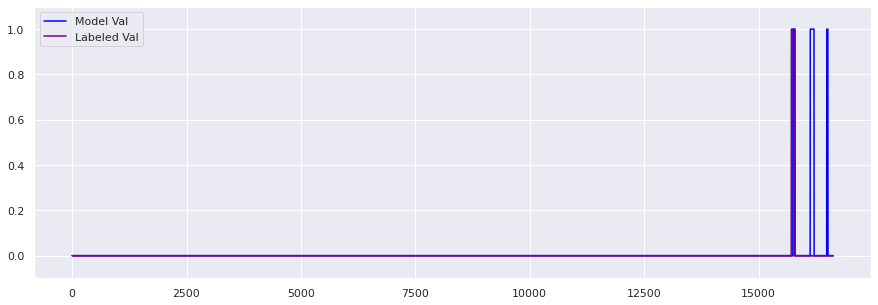

Percentage of Matching Boolean:  0.9907992062060256
True Positive Percent:  0.25675675675675674
False Positive Percent:  0.0026090649839208787


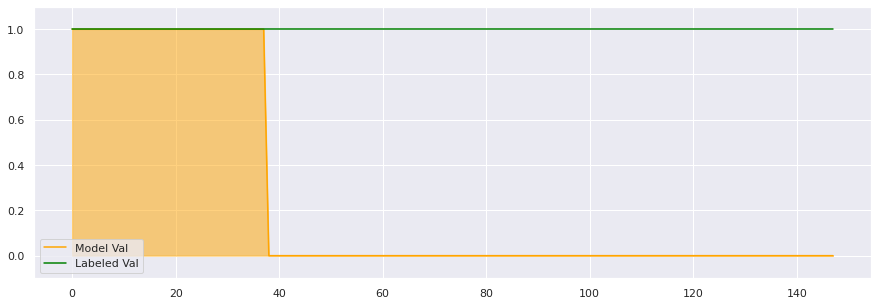

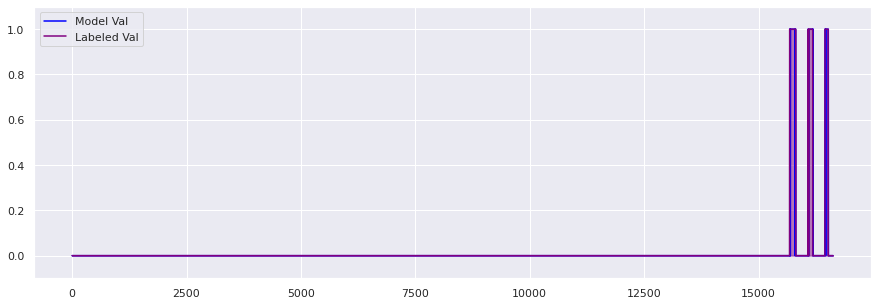

Percentage of Matching Boolean:  0.9977749714354441
True Positive Percent:  0.9744525547445255
False Positive Percent:  0.0018343014368694588


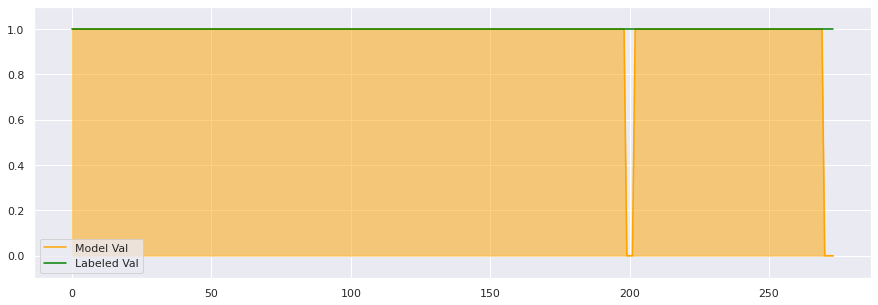

In [584]:
def comp_bool(predicted, labeled, threshold=.5, start=10500, end=13500):
    rcParams['figure.figsize'] = [15, 5]
    pred = np.array([1 if i > threshold else 0 for i in predicted]) #should filter?
    lbl = np.array([1 if i > threshold else 0 for i in labeled])
    plt.plot(pred, color='blue', label='Model Val')
    plt.plot(lbl, color='purple', label='Labeled Val')
    plt.fill_between([i for i in range(len(lbl))], lbl, alpha=.5, color='purple')  
    plt.legend()
    plt.ylim([-.1, 1.1])
    plt.show()
    dif = [1 if p == l else 0 for p, l in zip(pred, lbl)]
    dif_per = np.sum(dif) / len(dif)
    print("Percentage of Matching Boolean: ", dif_per)
    #false negatives
    fpos = lbl[pred == 1]
    fpos_per = np.sum(fpos) / fpos.shape[0]
    #false positives
    fneg = lbl[pred == 0]
    fneg_per = np.sum(fneg) / len(fneg)
    print("True Positive Percent: ", fpos_per)
    print("False Positive Percent: ", fneg_per)
    plt.ylim([-.1, 1.1])
    plt.plot(fpos, color='orange', label='Model Val')
    plt.fill_between([i for i in range(len(fpos))], fpos, alpha=.5, color='orange')
    plt.plot(pred[pred == 1], color='green', label='Labeled Val')
    plt.legend()
    plt.show()
    
# model = rand_for(X_train, y_train)
print(X_train.shape)
print(X.shape)
y_hat = reg.predict(X.copy())
y2_hat = clf.predict(X.copy())
comp_bool(y_hat, y)
comp_bool(y2_hat, y2)

In [585]:
# from sklearn.tree import export_graphviz# Export as dot file
# from graphviz import dot
# estimator = model.estimators_[5]
# export_graphviz(estimator, 
#     out_file='tree.dot', 
#     feature_names = X.columns,
#     class_names = y.name,
#     rounded = True, 
#     proportion = False, 
#     precision = 2, 
#     filled = True
#     )

# os.system('dot -Tps tree.dot -o tree.png -Gdpi=600')
# print("Saved Image to 'tree.png'")

### Compare Any number of Equal Length Outputs on the Same Plot

In [601]:
def side_by_side(np_iter, label_iter, start=0, stop=None):
    rcParams['figure.figsize'] = [15, 5]
    assert np_iter[0].shape == np_iter[1].shape
    stop = len(np_iter[0]) if not stop else stop
    if label_iter:
        assert len(np_iter) == len(label_iter)
    
    plt.clf()
    palette=sns.color_palette("flare", as_cmap=False)
    sns.set_theme(style="darkgrid", color_codes=True, palette=palette)
    
    if label_iter:
        h_axis = [i for i in range(len(np_iter[0][start:stop]))]
        for i, arr in enumerate(np_iter):   
            plt.plot(h_axis, arr[start:stop], color=palette[i], linestyle='-')
        plt.legend(labels=label_iter)
    else:
        for i, arr in enumerate(np_iter):   
            plt.plot(h_axis, arr[start:stop], color=palette[i], linestyle='-')
            
    plt.show()

### Run multiple functions for estimating model results

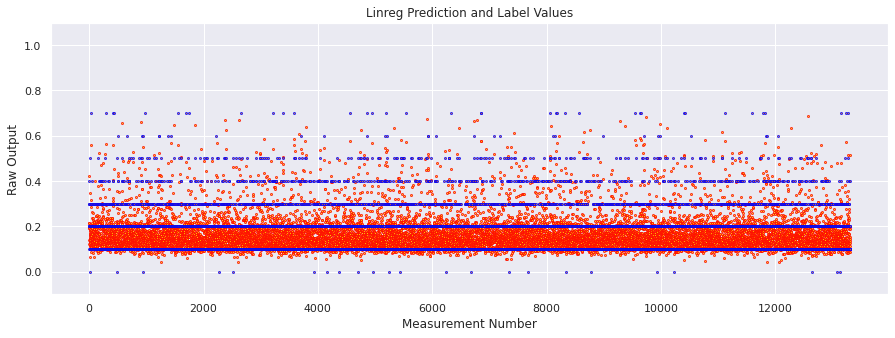

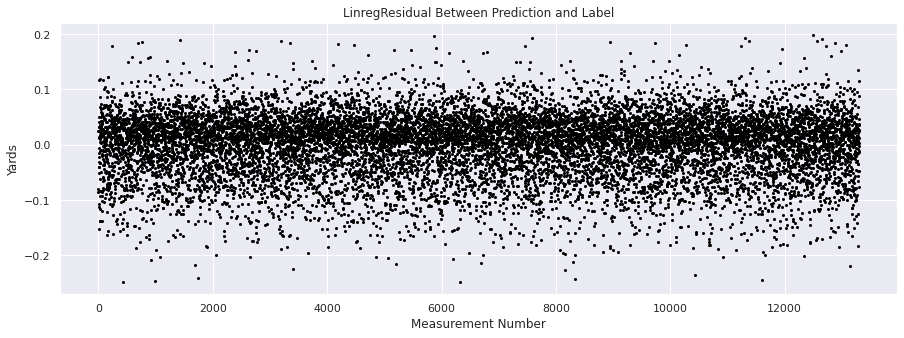

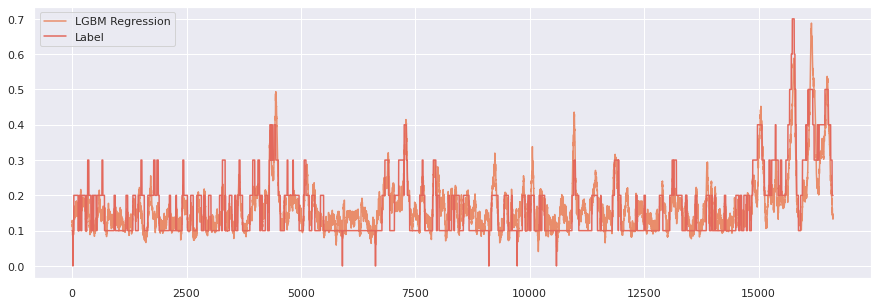

16629
16629


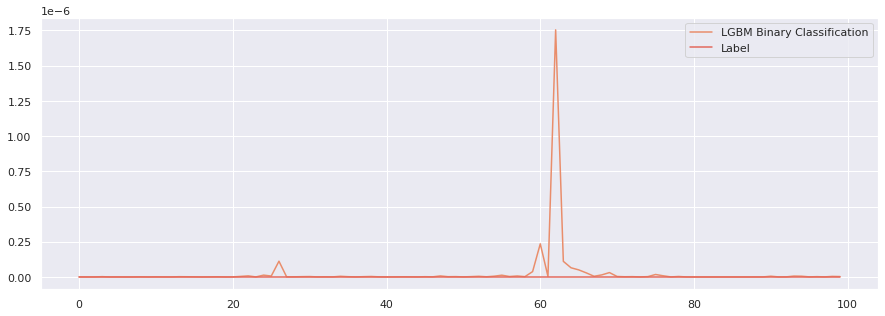

Done


In [602]:
y_hat_test = reg.predict(X_test)
plot_compare(y_hat_test, y_test)

y_hat = reg.predict(X)
side_by_side((y_hat, y), ("LGBM Regression", "Label"))

y2_hat = clf.predict(X)
print(y2_hat.size)
print(y2.size)
side_by_side((y2_hat, y2), ("LGBM Binary Classification", "Label"), start=100, stop=200)
print("Done")

### Test the output on another labeled dataset

       Unnamed: 0  distance  coverage  car_areas  car_ages  car_count  \
0              14  0.155660  0.112451   0.100029  0.023392   0.129032   
1              15  0.116028  0.083875   0.066456  0.009357   0.064516   
2              16  0.093062  0.069615   0.056540  0.010526   0.064516   
3              17  0.073066  0.117277   0.088660  0.012281   0.096774   
4              18  0.153752  0.172318   0.126542  0.014035   0.096774   
...           ...       ...       ...        ...       ...        ...   
17135       17225  0.169270  0.136122   0.105263  0.010526   0.096774   
17136       17226  0.131662  0.105896   0.089745  0.012281   0.096774   
17137       17227  0.103590  0.081279   0.077933  0.014035   0.096774   
17138       17228  0.057309  0.067753   0.069011  0.016374   0.129032   
17139       17229  0.007182  0.065688   0.067950  0.017544   0.096774   

        dropped  avg_speed   stopped    slowed  ...  avg_speed_sma  \
0      0.000000   0.432474  0.250000  0.750000  ...  

/home/nwcallahan/.local/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Unnamed: 0
Feature names seen at fit time, yet now missing:
- Unnamed0

  warnings.warn(message, FutureWarning)


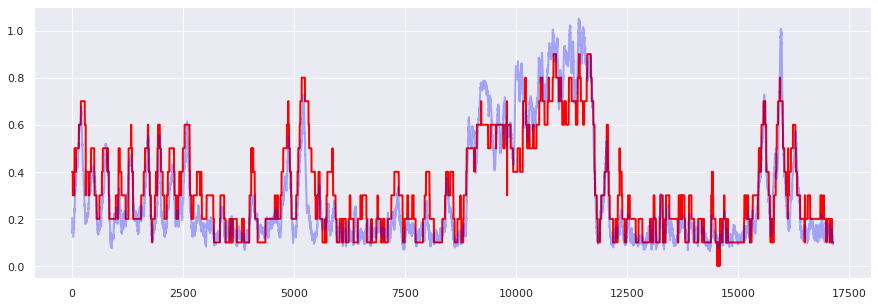

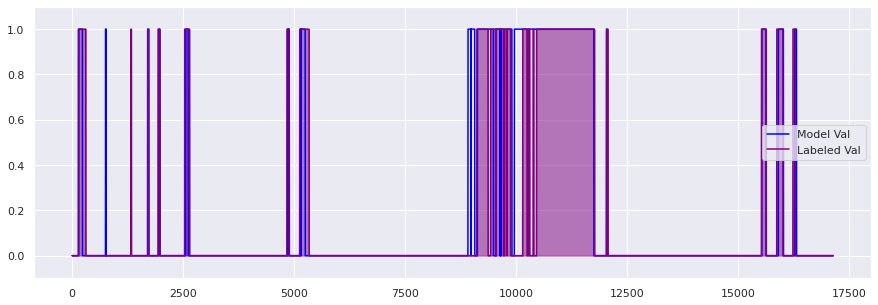

Percentage of Matching Boolean:  0.927071178529755
True Positive Percent:  0.7751314568512218
False Positive Percent:  0.03760696052347739


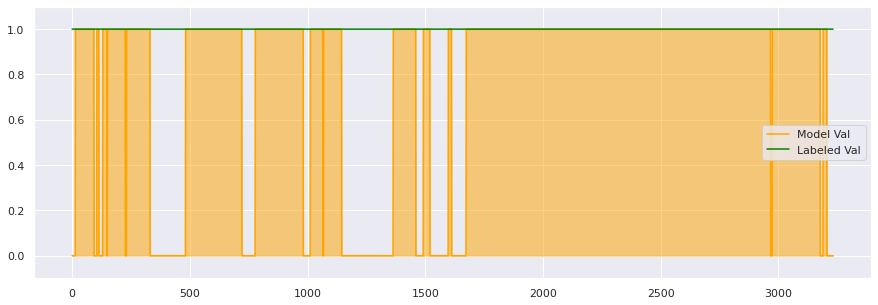

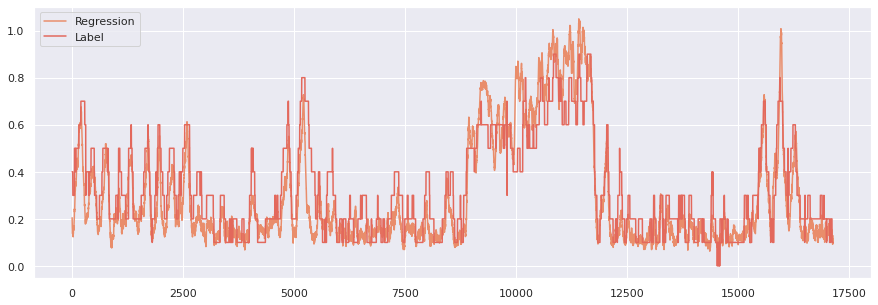

In [588]:
def test_external(model, summary_df_path, label_df_path):
    summary_df = pd.read_csv(summary_df_path)
    summary_df.dropna(inplace=True)
    summary_df = add_labels(summary_df, label_df_path)
    X, y, y2 = get_X_y(summary_df)
    print(X)
    y_hat = model.predict(X.copy())
#     X.plot(alpha=.2)
#     plt.show()
    
#     X.mean().plot()
#     plt.show()
    plt.clf()
    plt.plot(y, color='red', linewidth=2)
    plt.plot(y_hat, color='blue', linewidth=2, alpha=.3)
    plt.show()
    comp_bool(y_hat, y)
    side_by_side((y_hat, y), ("Regression", "Label"))

# X.plot(alpha=.2)
# plt.show()

# X.mean().plot()
# plt.show()
test_date = '05-05-2022'
test_summary_dir = f'/home/nwcallahan/SampleGraphics/summaries/summary_{test_date}_df.csv'
test_label_dir = f'/home/nwcallahan/SampleGraphics/labels/label_{test_date}_df.csv'

test_external(reg, test_summary_dir, test_label_dir)

#### Save the Model to a Joblib for Loading from Script

In [589]:
dump(reg, reg_model_path)
print("Regression Model Saved to", reg_model_path)

dump(clf, clf_model_path)
print("Binary Classifier Model Saved to", clf_model_path)

Regression Model Saved to /home/nwcallahan/SampleGraphics/reg_model.joblib
Binary Classifier Model Saved to /home/nwcallahan/SampleGraphics/clf_model.joblib


#### Optional Loading of Model from Joblib

In [590]:
loaded_reg = load(reg_model_path) 
print("Regression Model Loaded from", reg_model_path)
print(type(loaded_reg))

loaded_clf = load(clf_model_path) 
print("Binary Classifier Model Loaded from", clf_model_path)
print(type(loaded_clf))

Regression Model Loaded from /home/nwcallahan/SampleGraphics/reg_model.joblib
<class 'sklearn.linear_model._base.LinearRegression'>
Binary Classifier Model Loaded from /home/nwcallahan/SampleGraphics/clf_model.joblib
<class 'lightgbm.basic.Booster'>


### Generate a plot and DataFrame for an external dataset, ie an input that has not been labeled or used to fit the model. Used as input to video outputting function

/home/nwcallahan/.local/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Unnamed: 0
Feature names seen at fit time, yet now missing:
- Unnamed0

  warnings.warn(message, FutureWarning)


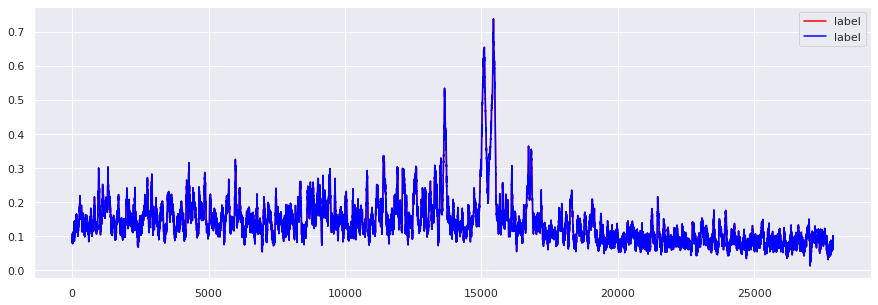

Saved to:  /home/nwcallahan/SampleGraphics/complete/video_summary_04-25-2022_df.csv


In [591]:
def summarize_external(summarize_date, reg_path='reg_model.joblib', clf_path='clf_model.joblib', save=True):
    reg = load(reg_path)
    clf = load(clf_path)
    summary_df_path = f'/home/nwcallahan/SampleGraphics/summaries/summary_{summarize_date}_df.csv'
    label_df_path = f'/home/nwcallahan/SampleGraphics/labels/label_{summarize_date}_df.csv'
    summary_df = pd.read_csv(summary_df_path)
    summary_df.dropna(inplace=True)
    X = get_X_y(summary_df, labeled=False)
    reg_label = reg.predict(X)
    bool_label = clf.predict(X)
    summary_df['reg_label'] = reg_label
    summary_df['clf_label'] = bool_label
    plt.plot(reg_label, color='red', label='label')
    plt.plot(reg_label, color='blue', label='label')
    plt.legend()
    plt.show()
    if save:
        save_path = f'/home/nwcallahan/SampleGraphics/complete/video_summary_{summarize_date}_df.csv'
        summary_df.to_csv(save_path)
        print("Saved to: ", save_path)
    return
    
summarize_date = '04-25-2022'
summarize_external(summarize_date)